# HW8.2: Wafer Defect Classification using DL models & techniques with Keras
---
###### Name: Devson Butani
###### ID: 000732711
###### LTU Honor Code: "I pledge that on all academic work that I submit, I will neither give nor receive unauthorized aid, nor will I present another person's work as my own."

# Get dataset from `Google Drive`

In [61]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Change directory to a drive folder of choice - Runs and models will be saved here
# %cd '/content/drive/MyDrive/DL_data'
%pwd # Verify

'/Users/cedar/Downloads/HW8'

In [62]:
train_dir = "wafer/train"
vali_dir = "wafer/validation"
test_dir = "wafer/test"

# Import Dependencies

In [63]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers

In [64]:
# Check if GPU available and linked to tensorflow so that keras can use it
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


# Setup Data Generator and Augmentation

In [65]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (150, 150) # 4X size of image??

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Rescale the pixel values from [0-255] to [0, 1] for easier NN processing
    rotation_range=15, 
    width_shift_range=0.05,  # lateral shift
    height_shift_range=0.05,  # vertical shift
    shear_range=0.1,
    zoom_range=0.02,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    # batch_size=18,
    shuffle=True,
    class_mode="categorical",
)

vali_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No DA
validation_generator = vali_datagen.flow_from_directory(
    vali_dir,
    target_size=img_size,
    # batch_size=10,
    shuffle=True,
    class_mode="categorical",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No DA
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=2116,  # a batch with all test images at once
    shuffle=False,
    class_mode="categorical",
)

Found 8224 images belonging to 9 classes.
Found 2115 images belonging to 9 classes.
Found 2116 images belonging to 9 classes.


# Build CNN

In [66]:
def build_model():
    model = models.Sequential()

    model.add(layers.DepthwiseConv2D((3, 3), activation="relu", input_shape=(150, 150, 3)))
    model.add(layers.DepthwiseConv2D((5, 5), activation="relu"))
    # model.add(layers.DepthwiseConv2D((7, 7), activation="relu"))
    model.add(layers.MaxPooling2D((3, 3)))
    
    model.add(layers.Conv2D(7, (11, 11), activation="relu"))
    model.add(layers.Conv2D(13, (13, 13), activation="relu"))
    model.add(layers.MaxPooling2D((3, 3)))
    model.add(layers.Flatten())  # CNN flattened
    
    model.add(layers.Dense(512, activation="relu"))  # DNN
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(47, activation="relu"))
    model.add(layers.Dense(9, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"],
    )
    return model

In [67]:
# Calculate steps per epoch
step_train = train_generator.n // train_generator.batch_size
step_val = validation_generator.n // validation_generator.batch_size

# Start Training and Validation
model_DA = build_model()
model_DA.summary()
history = model_DA.fit(
    train_generator,
    steps_per_epoch=step_train,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=step_val,
    verbose=2,
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 depthwise_conv2d_30 (Depthw  (None, 148, 148, 3)      30        
 iseConv2D)                                                      
                                                                 
 depthwise_conv2d_31 (Depthw  (None, 144, 144, 3)      78        
 iseConv2D)                                                      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 48, 48, 3)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 38, 38, 7)         2548      
                                                                 
 conv2d_20 (Conv2D)          (None, 26, 26, 13)        15392     
                                                      

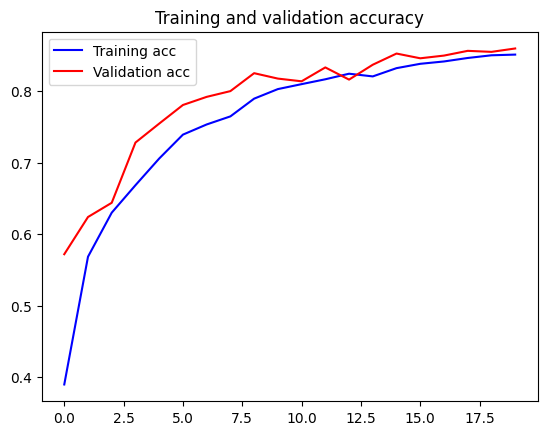

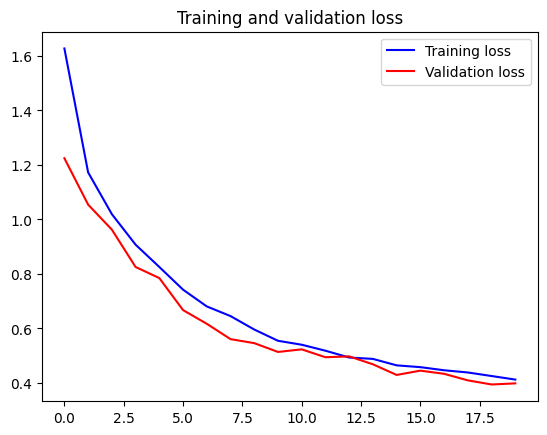

In [68]:
import matplotlib.pyplot as plt

acc2 = history.history["accuracy"]
val_acc2 = history.history["val_accuracy"]
loss2 = history.history["loss"]
val_loss2 = history.history["val_loss"]

epochs = range(len(acc2))

plt.plot(epochs, acc2, "b", label="Training acc")
plt.plot(epochs, val_acc2, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss2, "b", label="Training loss")
plt.plot(epochs, val_loss2, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [69]:
import os.path

path, dirs, files = next(os.walk("/Users/cedar/Downloads/HW8/history_files"))
file_count = len(files)
save_path = "history_files/"
name_of_file = "wafer_model_"
completeName = os.path.join(save_path, name_of_file + str(file_count) + ".h5")
print(completeName)
model_DA.save(completeName)

history_files/wafer_model_26.h5


# Test the model

In [70]:
# Run the test dataset to find the accuracy
test_loss, test_acc = model_DA.evaluate(test_generator, steps=1)  # generator will get both data and label
print(f"test acc: {test_acc*100.0:.2f}%")

1/1 [==============================] - 2s 2s/step - loss: 0.3706 - accuracy: 0.8667
test acc: 86.67%


Found 2116 images belonging to 9 classes.
1/1 [==============================] - 1s 509ms/step


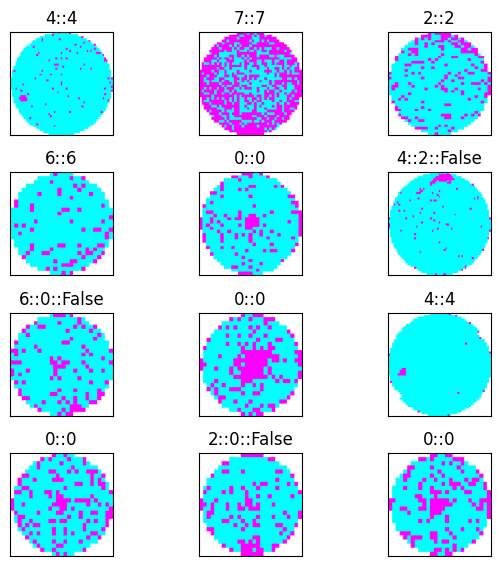

In [72]:
# make a copy of the test set but shuffled for display
t_datagen = ImageDataGenerator(rescale=1.0 / 255)  # No DA
t_generator = t_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=2116,  # a batch with all test images at once
    shuffle=True,
    class_mode="categorical",
)

# Plot the results, actual v/s model confidence
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
images = t_generator[0][0]
labels = t_generator[0][1]
results = model_DA.predict(t_generator)


for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout()
    plt.imshow(images[i])
    actual = np.argmax(labels[i].round(1))
    predicted = np.argmax(results[i].round(1))
    title = f"{actual}::{predicted}"
    if actual - predicted < -0.5:  # false positive or false negative
        title = f"{actual}::{predicted}::False"
    if actual - predicted > 0.5:
        title = f"{actual}::{predicted}::False"
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

> Since this is a multiclass classification problem, false positives and false negatives should be simply false as the classes don't match. If certain classes are thought to be good(okay) OR bad(unusable) wafers, we can adjust accordingly using a second classifier.